Author: Lijing Wang, lijing52@stanford.edu (2021)

# Setup the notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib
import matplotlib as mpl
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,PrecisionRecallDisplay
warnings.filterwarnings("ignore")

#mpl.rcParams['figure.dpi'] = 144
plt.rcParams.update({'font.size': 13})

Clone the Cape Smith dataset to the notebook.

In [ ]:
! git clone https://github.com/lijingwang/SpatialAggregation_Capesmith.git
os.chdir('/content/SpatialAggregation_Capesmith')

Cloning into 'SpatialAggregation_Capesmith'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 36 (delta 6), reused 5 (delta 1), pack-reused 21
Unpacking objects: 100% (36/36), done.


**Dimension of the study area**
* Domain size: ~ 7.7 km x 4.5 km 

* Grid resolution: 6m 

* Raster size: 1284 in x direction x 751 in y direction

In [3]:
x_dim, y_dim = 1284, 751

# Load Cape Smith dataset

**Load the raster remote sensing data and rock type labels**

Load the raster formated Day1 and Day 20 data

In [3]:
# Remote sensing data variable: X
X_Day1 = np.load('RemoteSensingRaster_Day1.npy')
X_Day20 = np.load('RemoteSensingRaster_Day20.npy')

# Rock type label variable: y
y_Day1 = np.load('RockLabelRaster_Day1.npy')
y_Day20 = np.load('RockLabelRaster_Day20.npy')

Load the entire remote sensing data

In [4]:
X_all = np.load('RemoteSensingRaster_all.npy')
# Get the names of each remote sensing data type
X_dir_list = [filename for filename in os.listdir('.') if filename.endswith(".tif")]
X_dir_list.sort()
name_list = [X_dir.split('.')[0] for X_dir in X_dir_list]
# Load the entire land cover mask 
cover_type_vis = np.load('land_cover_mask_Raster.npy')

Define which day to work with, either 'Day1' or 'Day20'.

In [5]:
# Define X, y
## You can change it into Day 1 or Day 20
Day = 'Day1'
if Day == 'Day1':
    X = np.copy(X_Day1)
    y = np.copy(y_Day1)
elif Day == 'Day20': 
    X = np.copy(X_Day20)
    y = np.copy(y_Day20)

Split the dataset to training and test data by 80% and 20%.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Predicting with Bayes' rule

In [7]:
results = {}

## Simple classification task with Bayes: one variable
We first start with a simple Bayesian prediction by using only one band from the remote sensing data.

p(c|x) = p(x|c)p(c)/p(x)

In [14]:
# select one variable x: band00
selected_band = 'band00'
selected_index = np.where(selected_band==np.array(name_list))[0][0]

# calculate priors and likelihoods
from scipy import stats
priors = [np.sum(y_train==i)/len(y_train) for i in range(len(np.unique(y_train)))]
# Calculate likelihood using KDE
likelihoods = [stats.gaussian_kde(X_train[y_train==i,selected_index])
               for i in range(len(np.unique(y_train)))]

Visualize likelihood p(x|c)

Text(0, 0.5, 'density')

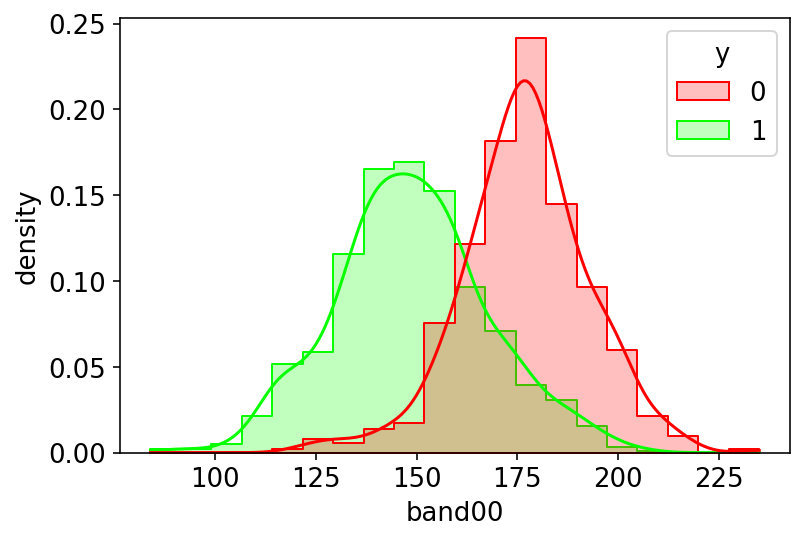

In [15]:
# 
X_train_pd = pd.DataFrame(X_train,columns=name_list)
X_train_pd['y'] = np.array(y_train,dtype = 'int64')
X_train_pd['weight'] = X_train_pd['y']
for i in range(len(np.unique(y_train))):
    X_train_pd['weight'][X_train_pd['y']==i] = 1/np.sum(X_train_pd['y']==i)

sns.histplot(data=X_train_pd, x=selected_band, hue="y",stat="count", weights = 'weight',
             kde=True, palette = 'hsv',element="step", fill=True,bins = 20,hue_norm=(0,3))
plt.ylabel('density')

Calculate the posterior p(c|x)

In [16]:
def posterior_Bayes(x,likelihoods,priors):
    pos= [likelihoods[i](x)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

Plot confusion matrix on test data

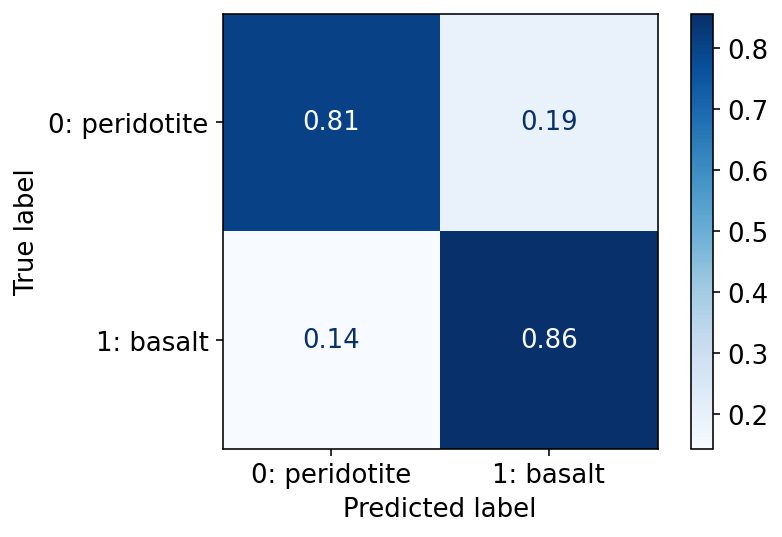

In [17]:
results['Bayes: x'] = posterior_Bayes(X_test[:,selected_index],likelihoods,priors)
y_pred = np.argmax(results['Bayes: x'],axis = 1)
if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

Next, we use the trained Bayesian model to predict rock types on the entire area

In [18]:
y_pred = np.argmax(posterior_Bayes(X_all[:,selected_index],likelihoods,priors),axis = 1)
y_pred = np.array(y_pred.reshape(y_dim, x_dim),dtype = 'float64')

(-0.5, 1283.5, 750.5, -0.5)

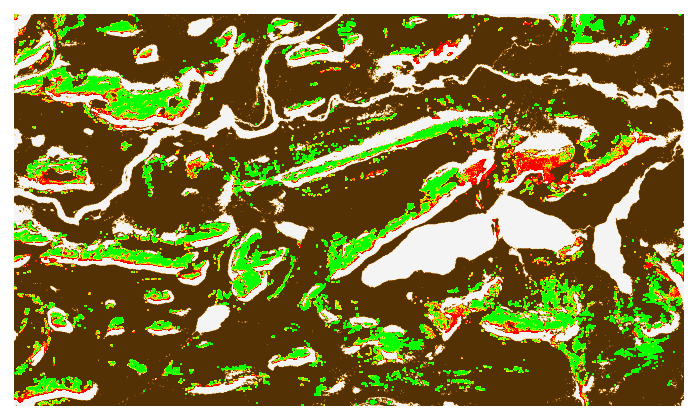

In [13]:
# Visualize the predicted rock types of the entire study area
cover_type_vis[cover_type_vis==1] = np.nan
plt.imshow(y_pred,cmap ='hsv',vmin = 0,vmax = 3)
plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
plt.axis('off')

## Naïve Bayes with two variables
Now we move to a more challenging prediction problem, prediction with multi-variables. Again, to start simple, we use two variables. That is to use two bands from the remote sensing data as the predictor. 

p(c|x1,x2) = p(x1|c)p(x2|c)p(c)/p(x1,x2) 

Below, we choose band00 and band007 as example. You can also play around with various combinations of thepredictors! 


In [22]:
selected_band_list = ['band00','band07']

We first investigate the selected two predictors to understand the data. This is to check the conditional independence of the selected predictors. 

<AxesSubplot:xlabel='band00', ylabel='band07'>

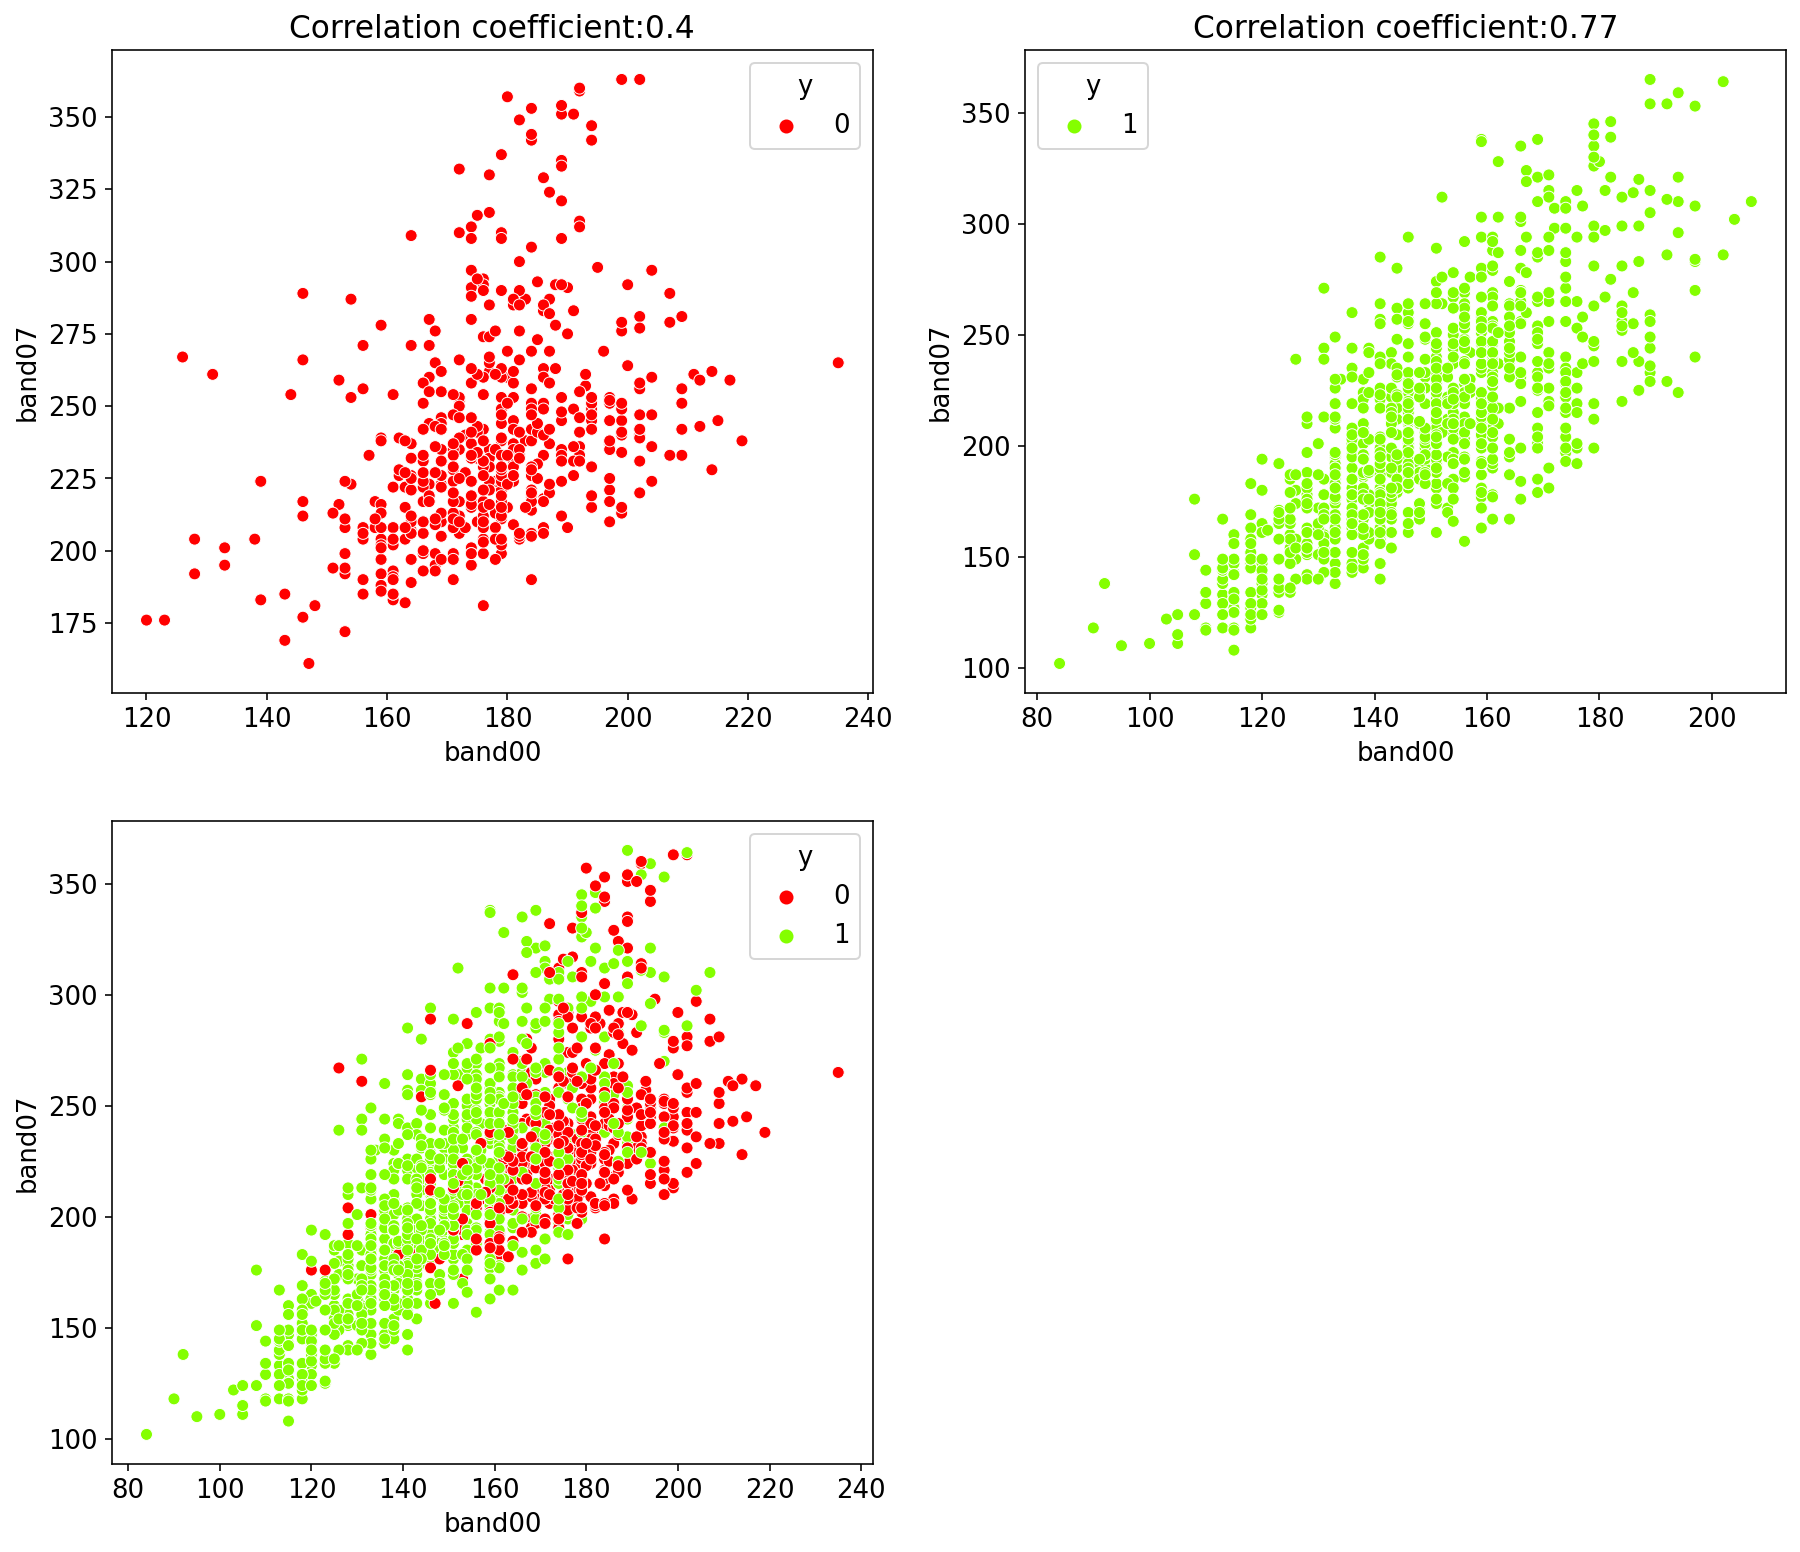

In [23]:

plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.scatterplot(data=X_train_pd[X_train_pd['y']==i], 
                    x=selected_band_list[0], 
                    y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4))
    corr = np.corrcoef(X_train_pd[X_train_pd['y']==i][selected_band_list[0]],
                       X_train_pd[X_train_pd['y']==i][selected_band_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

ax = plt.subplot(2, 2, len(priors)+1)
sns.scatterplot(data=X_train_pd, x=selected_band_list[0], y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4))

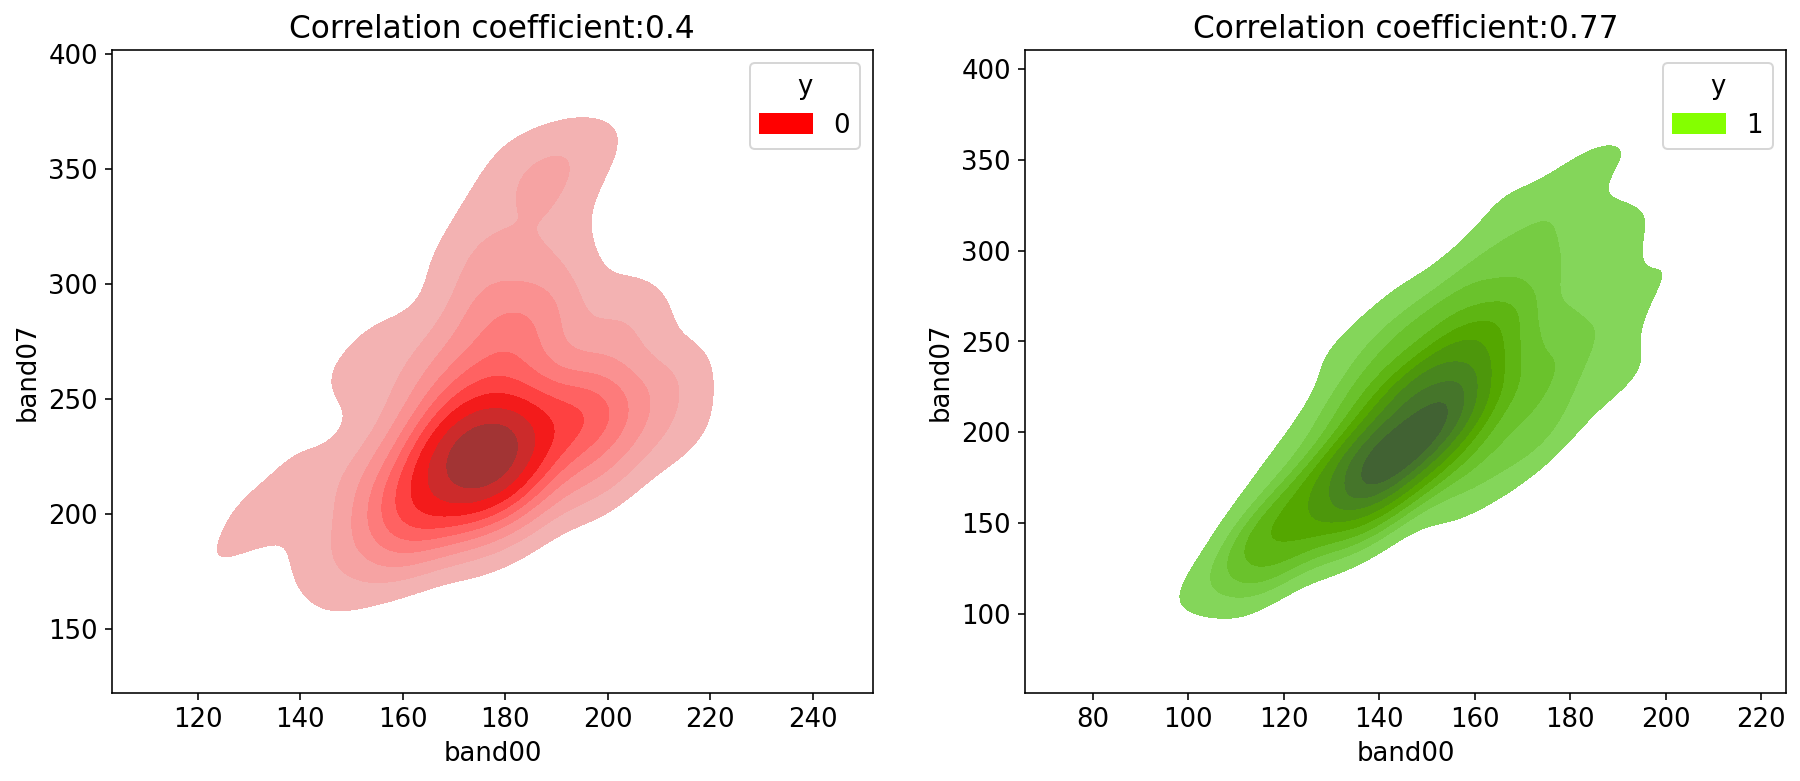

In [24]:
plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.kdeplot(data=X_train_pd[X_train_pd['y']==i], 
                    x=selected_band_list[0], 
                    y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4),fill=True)
    corr = np.corrcoef(X_train_pd[X_train_pd['y']==i][selected_band_list[0]],
                       X_train_pd[X_train_pd['y']==i][selected_band_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

Now refer to the book to understand the conditional independance using the above generated plots. 

Next, we calcualte the likelihood and posterior

In [25]:
# calculate likelihoods
likelihoods_list = {}
for selected_band in selected_band_list:
    selected_index = np.where(selected_band==np.array(name_list))[0][0]
    likelihoods = [stats.gaussian_kde(X_train[y_train==i,selected_index])
                   for i in range(len(np.unique(y_train)))]
    likelihoods_list[selected_band] = likelihoods

In [26]:
# calculate the posterior p(c|x1,x2) = p(x1|c)p(x2|c)p(c)/p(x1,x2) 
def posterior_Naive(x,priors,likelihoods_list):
    selected_band = selected_band_list[0]
    likelihoods = likelihoods_list[selected_band]
    selected_index = np.where(selected_band==np.array(name_list))[0][0]
    
    pos= [likelihoods[i](x[:,selected_index])*priors[i] for i in range(len(likelihoods))]
    for selected_band in selected_band_list[1:]:
        selected_index = np.where(selected_band==np.array(name_list))[0][0]
        likelihoods = likelihoods_list[selected_band]
        pos = [pos[i]*likelihoods[i](x[:,selected_index]) for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

Plot confusion matrix on test data

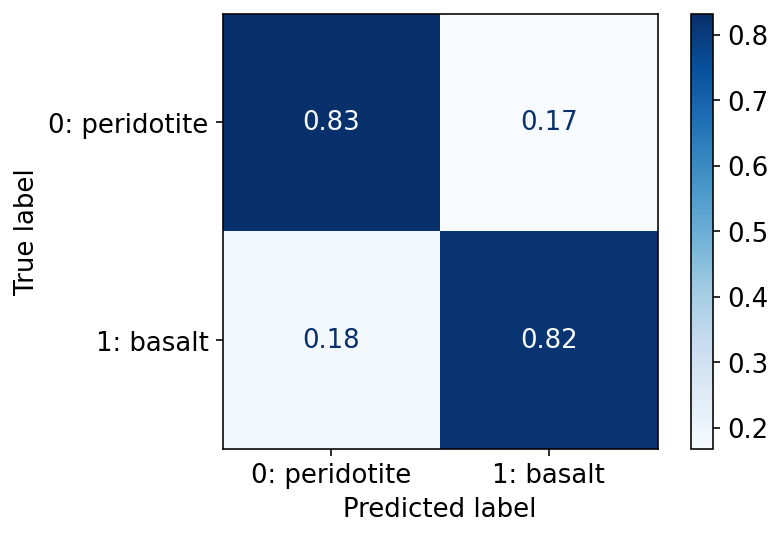

In [27]:
# confusion matrix on test data
results['Naïve Bayes: x1,x2'] = posterior_Naive(X_test,priors,likelihoods_list)
y_pred = np.argmax(results['Naïve Bayes: x1,x2'],axis = 1)

if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

Finally, we use the multivaraite Bayesian model to predict rock types of the entire area.

In [28]:
y_pred = np.argmax(posterior_Naive(X_all,priors,likelihoods_list),axis = 1)
y_pred = np.array(y_pred.reshape(y_dim, x_dim),dtype = 'float64')

(-0.5, 1283.5, 750.5, -0.5)

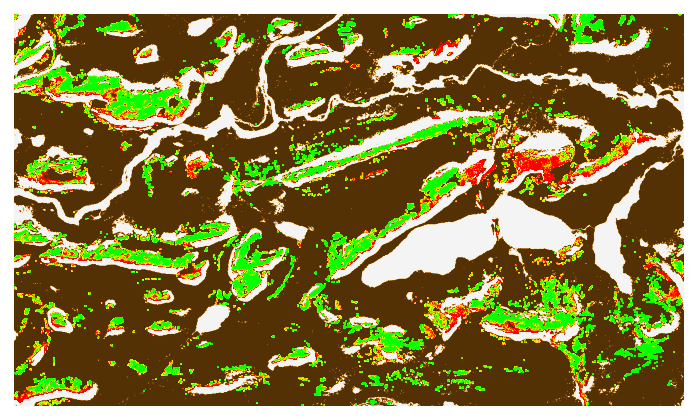

In [29]:
plt.imshow(y_pred,cmap ='hsv',vmin = 0,vmax = 3)
plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
plt.axis('off')

## Full Bayes with two variables
p(c|x1,x2) = p(x1,x2|c)p(c)/p(x1,x2) 

In [34]:
# calculate likelihoods
selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
likelihoods = [stats.gaussian_kde(X_train[y_train==i,:][:,selected_index].T)
               for i in range(len(np.unique(y_train)))]

In [35]:
# calculate the posterior p(c|x1,x2) = p(x1,x2|c)p(c)/p(x1,x2) 
def posterior_full_Bayes(x,likelihoods,priors):
    selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
    pos= [likelihoods[i](x[:,selected_index].T)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

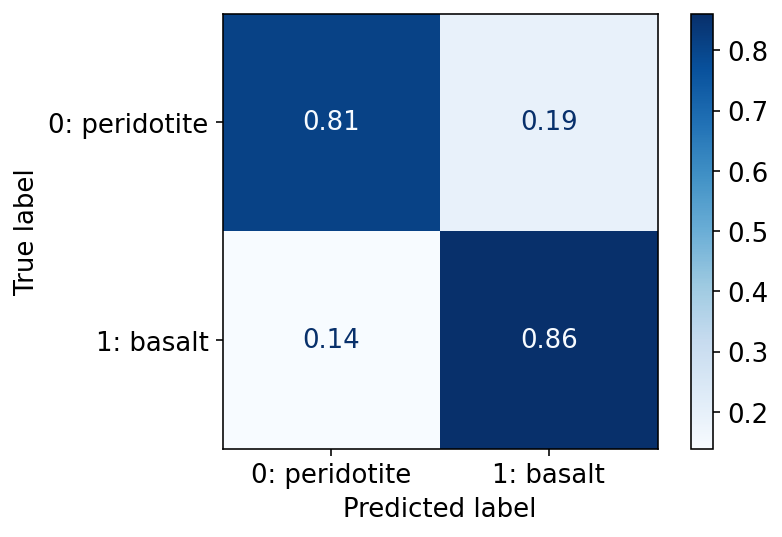

In [36]:
# confusion matrix on test data
results['Full Bayes: x1,x2'] = posterior_full_Bayes(X_test,likelihoods,priors)
y_pred = np.argmax(results['Full Bayes: x1,x2'],axis = 1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

## Precision recall analysis

We can also plot the precision and recall analysis by varying the classifying threshold from between [0, 1]

In [30]:
def precision_recall(y_pred_prob,threshold,y_test = y_test):
    prediction = (y_pred_prob[:,0]>threshold)
    TP = np.sum(prediction[y_test==0]) # 
    PP = np.sum(prediction) # predicted positive
    P = np.sum(y_test==0)# positive
    precision = TP/PP
    if np.isnan(precision):
        precision = 1
    recall = TP/P
    return [precision,recall]

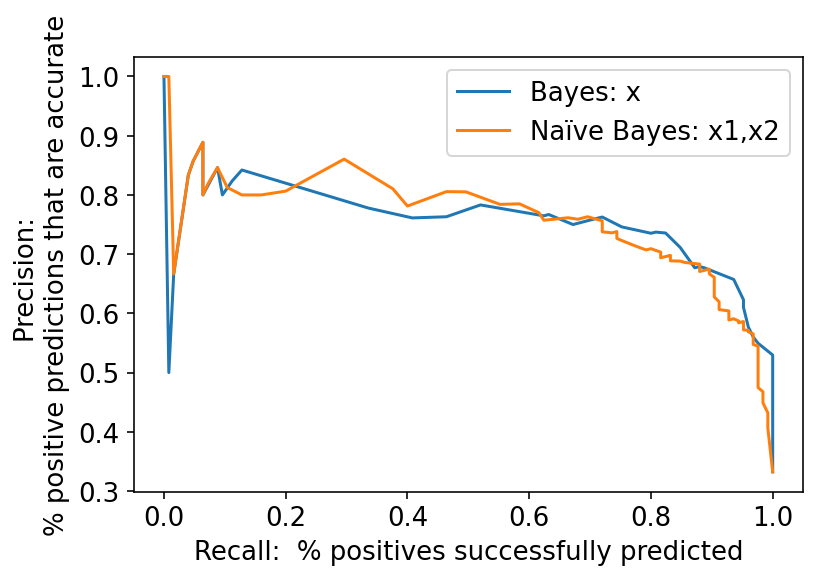

In [31]:
for method in results.keys():
    PR = np.array([precision_recall(results[method],threshold) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = method)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()

## Full Bayes: Day 1 and Day 20

We apply the full naïve bayes protocol to the entire cape smith data, using all the 7 remonte sensing bands

In [32]:
pred_map = {}
pred_entropy = {}
y_test_list = {}

In [37]:
# Full Bayes: Day 1 and Day 20
for Day in ['Day1','Day20']:
    if Day == 'Day1':
        X = np.copy(X_Day1)
        y = np.copy(y_Day1)
    elif Day == 'Day20': 
        X = np.copy(X_Day20)
        y = np.copy(y_Day20)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # calculate priors
    priors = [np.sum(y_train==i)/len(y_train) for i in range(len(np.unique(y_train)))]
    
    # calculate likelihoods
    selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
    likelihoods = [stats.gaussian_kde(X_train[y_train==i,:][:,selected_index].T)
                   for i in range(len(np.unique(y_train)))]
    
    # inference: test dataset
    y_test_list[Day] = y_test
    results['Full Bayes '+Day+': x1,x2'] = posterior_full_Bayes(X_test,likelihoods,priors)
    
    # inference: full map
    y_pred_prob = posterior_full_Bayes(X_all,likelihoods,priors)
    y_pred = np.argmax(y_pred_prob,axis = 1)
    y_pred = np.array(y_pred.reshape(y_dim, x_dim),dtype = 'float64')
    pred_map[Day] = y_pred
    # inference: entropy
    entropy = -y_pred_prob[:,0]*np.log10(y_pred_prob[:,0])
    entropy = entropy.reshape(y_dim, x_dim)
    pred_entropy[Day] = entropy

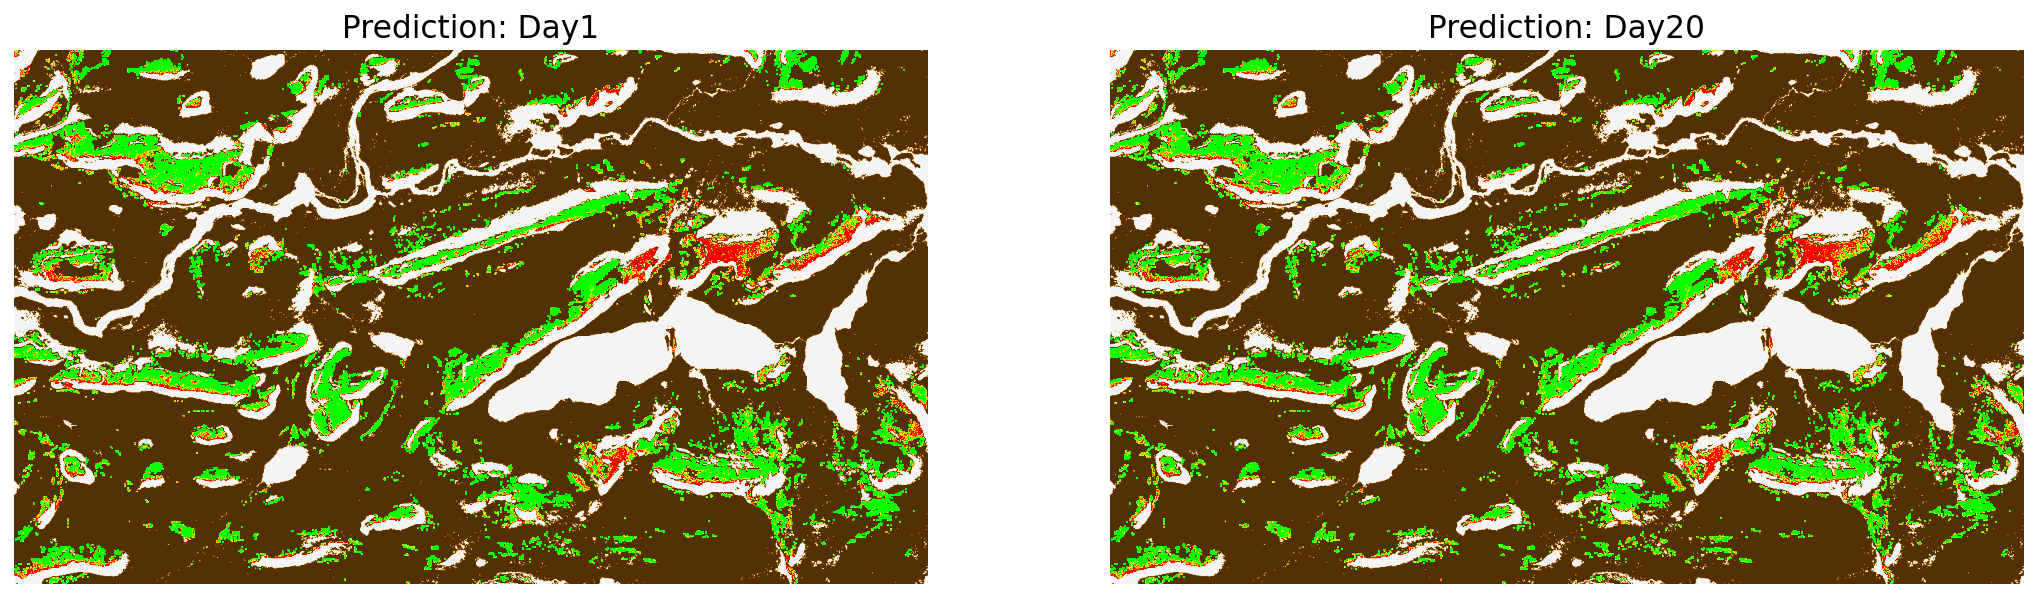

In [38]:
plt.figure(figsize=(18,6))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_map[Day],cmap ='hsv',vmin = 0,vmax = 3)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Prediction: '+Day)
    i = i+1

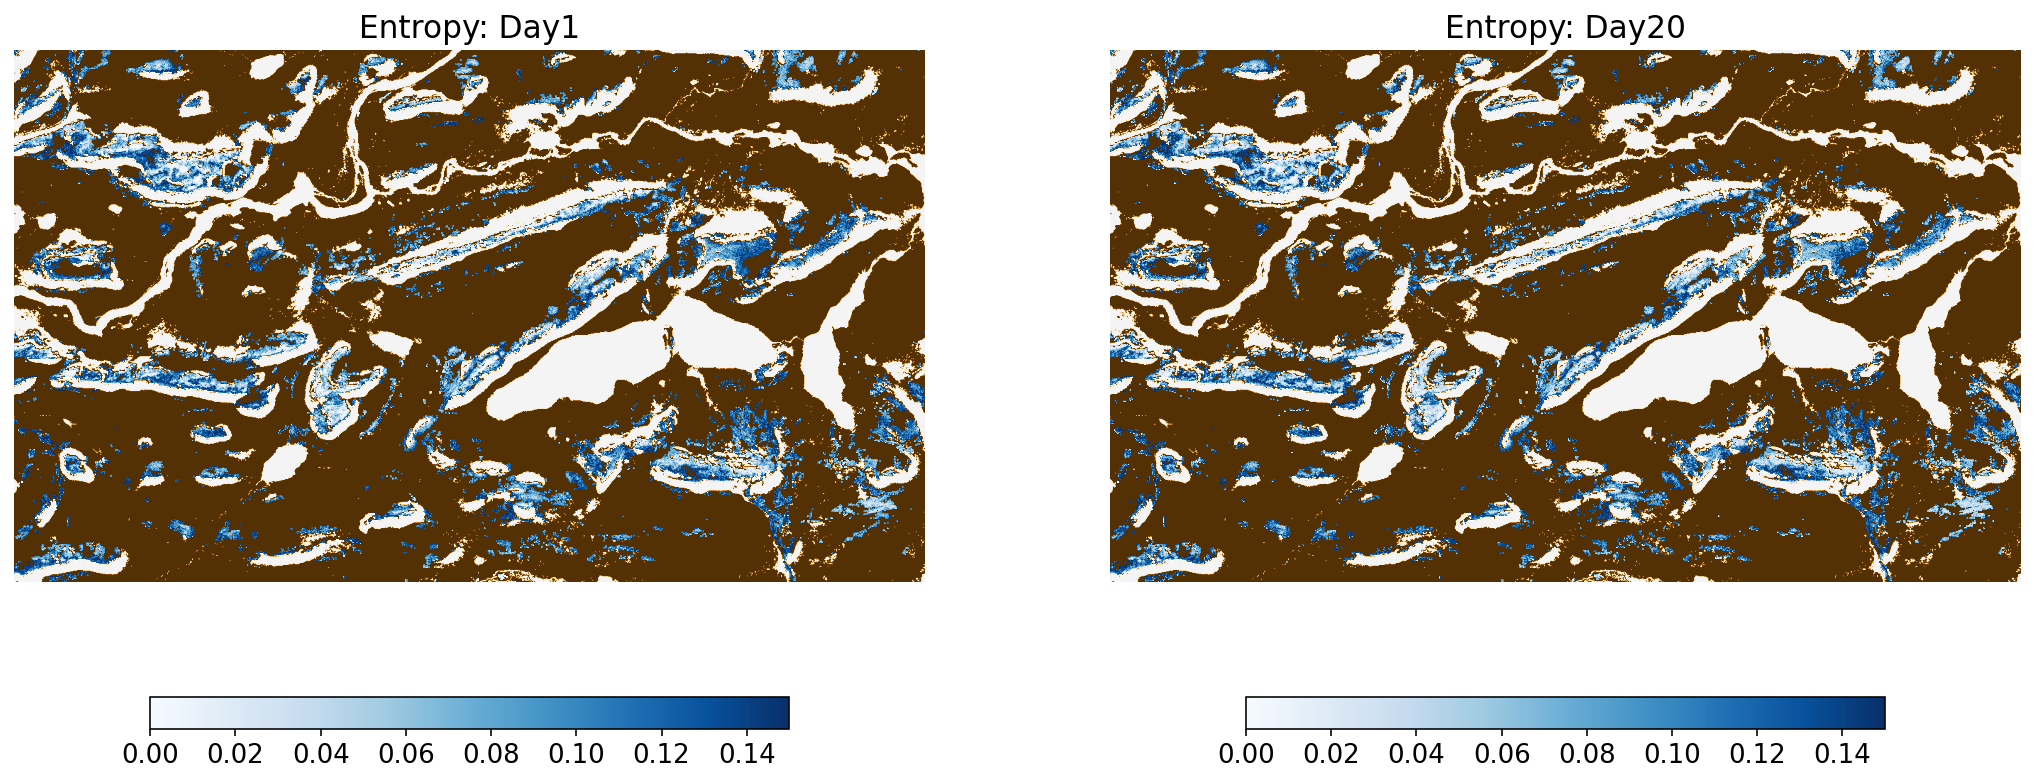

In [39]:
plt.figure(figsize=(18,7))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_entropy[Day],cmap = 'Blues',vmin = 0,vmax = 0.15)
    plt.colorbar(orientation = 'horizontal',shrink = 0.7)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Entropy: '+Day)
    i = i+1

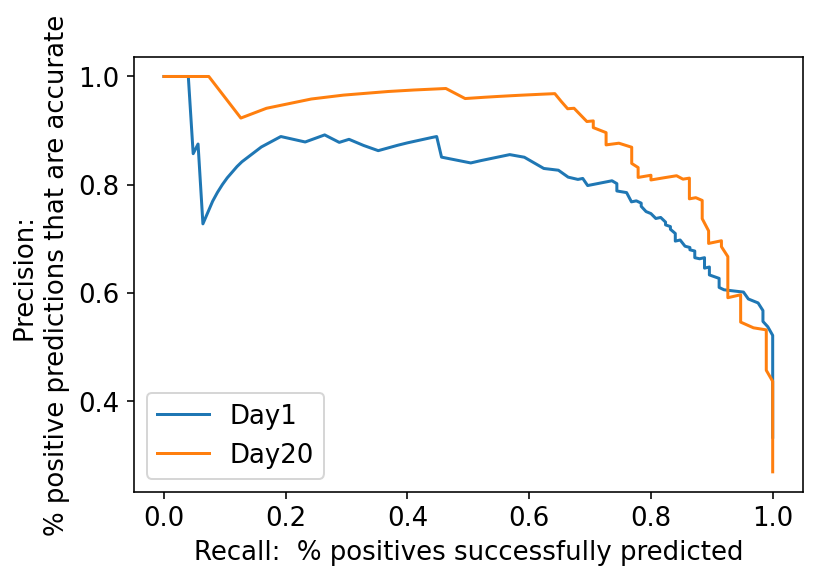

In [40]:
for Day in ['Day1','Day20']:
    PR = np.array([precision_recall(results['Full Bayes '+Day+': x1,x2'], threshold,
                                    y_test_list[Day]) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = Day)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf


### One variable - logistic regression demonstration

We first take a few band00 data samples from Cape Smith and show how the logistic function merges. 

In [63]:
dataset = pd.read_csv('LogisticRegression_data.csv')

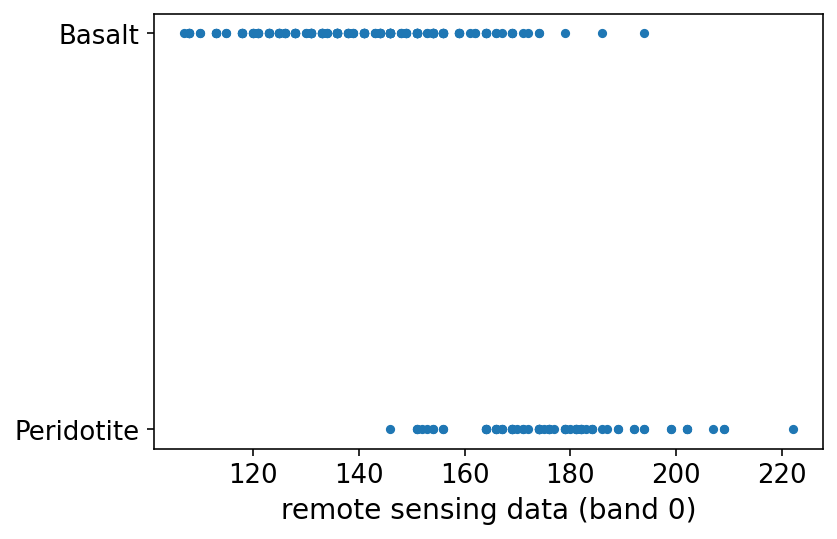

In [65]:
# select one variable x: band00
X = dataset['band_00']
y = dataset['rock_type']
plt.scatter(X, y,s = 13, label = 'samples')
plt.yticks([0,1], ['Peridotite', 'Basalt'], fontsize=13)
plt.xlabel('remote sensing data (band 0)', fontsize=14)
plt.show()

In logistic regression, we fit a linear regression model on $\text{logit}(Y)$:

$$\text{logit}(Y) = \beta_0+\beta_1x$$

$$P(Y) = \frac{1}{1+\exp(-(\beta_0+\beta_1x))}$$

In [66]:
# dataset = pd.DataFrame(data=np.c_[X_test, y_test], columns=['band_00', 'rock_type'])
# dataset.to_csv('LogisticRegression_data.csv', index=False)

In [68]:
linear_reg = smf.ols(formula='rock_type ~ band_00', data=dataset)
linear_reg = linear_reg.fit()

logit_reg = smf.logit(formula='rock_type ~ band_00', data=dataset)
logit_reg = logit_reg.fit()
print(linear_reg.summary())

Optimization terminated successfully.
         Current function value: 0.258683
         Iterations 8
                            OLS Regression Results                            
Dep. Variable:              rock_type   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     279.2
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           4.80e-44
Time:                        23:43:38   Log-Likelihood:                -76.150
No. Observations:                 284   AIC:                             156.3
Df Residuals:                     282   BIC:                             163.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

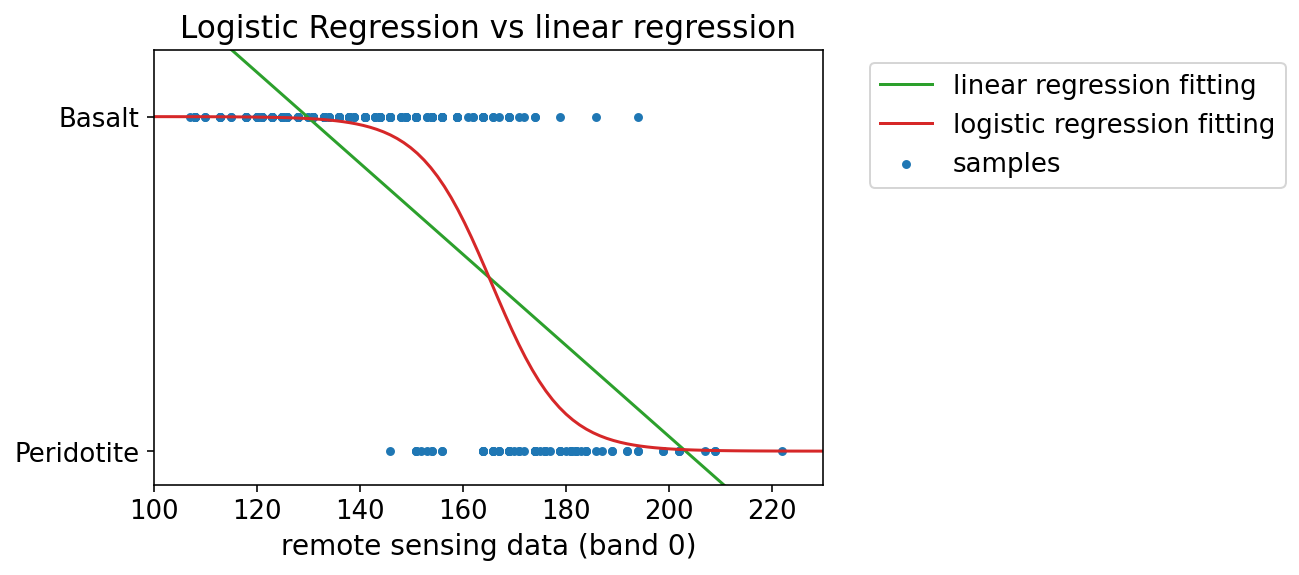

In [70]:
plt.scatter(dataset['band_00'],dataset['rock_type'],s = 12, label = 'samples')

plt.plot(np.linspace(100,230,num = 100),
         linear_reg.predict(exog=dict(band_00=np.linspace(100,230,num = 100))),
         label = 'linear regression fitting',color= 'C2')
plt.plot(np.linspace(100,230,num = 100),
         logit_reg.predict(exog=dict(band_00=np.linspace(100,230,num = 100))),
         label = 'logistic regression fitting',color= 'C3')
plt.ylim(-0.1, 1.2), plt.xlim(100, 230)
plt.yticks([0,1], ['Peridotite', 'Basalt'], fontsize=13)
plt.xlabel('remote sensing data (band 0)', fontsize=14)
plt.title('Logistic Regression vs linear regression')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [71]:
logit_reg.params
# P_y = 1/(1+np.exp(0.144623*dataset['band_0'].values-23.961073))
# plt.scatter(dataset['band_0'],dataset['Rock_type'], label = 'samples')
# plt.scatter(dataset['band_0'],P_y, label = 'Logitstic regression using data samples')
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.show()

Intercept    23.961073
band_00      -0.144623
dtype: float64

Plot log-likelihood as a function of beta1 and beta0

$L = \Pi(P(x)^{y_i}*(1-P(x))^{1-y_i})$

In [73]:
from tqdm.notebook import tqdm
n_samples = 500
beta1_max, beta1_min = 0.05, -0.35
beta0_max, beta0_min = 45,0
beta1 = np.linspace(beta1_min,beta1_max, n_samples)
beta0 = np.linspace(beta0_min, beta0_max,  n_samples-1)
Likelihood_smpls = []
for beta0_ in tqdm(beta0):
    likelihood_ = []
    
    for beta1_ in beta1:

        P_y = 1/(1+np.exp(-beta1_*dataset['band_00'].values-beta0_))

        likelihood_samples = (P_y**dataset['rock_type'].values) *((1-P_y)**(1-dataset['rock_type'].values))
        likelihood = np.prod(likelihood_samples)
        likelihood_.append(likelihood)
    Likelihood_smpls.append(np.asarray(likelihood_))
loglikeli_smpls = np.log(np.asarray(Likelihood_smpls))

  0%|          | 0/499 [00:00<?, ?it/s]

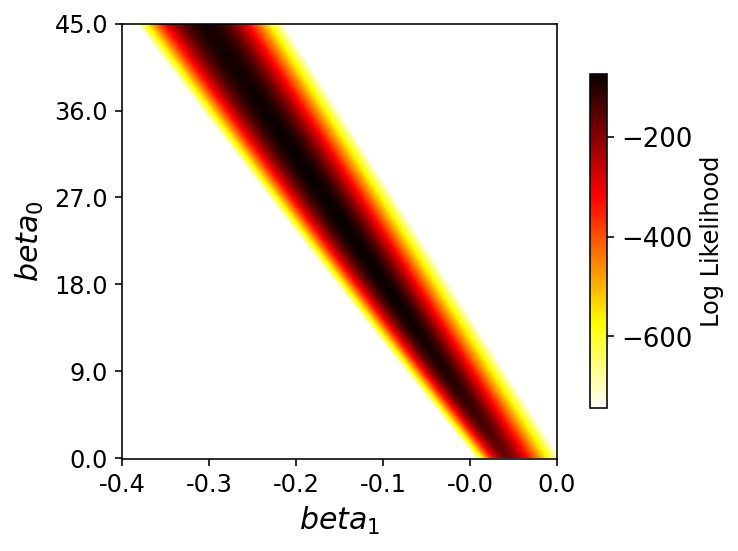

In [74]:
plt.imshow(loglikeli_smpls, cmap='hot_r', origin='lower')
plt.ylabel('$beta_0$', fontsize=15), plt.xlabel('$beta_1$', fontsize=15)
plt.xticks(np.arange(0, n_samples+1, 100), np.round(np.linspace(beta1_min,beta1_max, 6), 1), fontsize=12)
plt.yticks(np.arange(0, n_samples+1, 100), np.round(np.linspace(beta0_min,beta0_max, 6), 1),  fontsize=12)
cbar = plt.colorbar(fraction=0.025)
cbar.set_label('Log Likelihood', fontsize=12)
plt.show()

### Apply to entire Cape Smith

In [ ]:
pred_map = {}
results = {}
pred_entropy = {}
y_test_list = {}

In [ ]:
# Full Bayes: Day 1 and Day 20
for Day in ['Day1','Day20']:
    if Day == 'Day1':
        X = np.copy(X_Day1)
        y = np.copy(y_Day1)
    elif Day == 'Day20': 
        X = np.copy(X_Day20)
        y = np.copy(y_Day20)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    
    # Train the logistic regression model
    clf_LR = LogisticRegression(random_state=0, 
                                penalty='none').fit(X_train,  
                                                   y_train)
    # inference: test dataset
    y_test_list[Day] = y_test
    results['Logistic Regression '+Day] = clf_LR.predict_proba(X_test)
    
    # inference: full map
    y_pred_prob = clf_LR.predict_proba(X_all)
    y_pred = np.argmax(y_pred_prob,axis = 1)

    y_pred = np.array(y_pred.reshape(WV_band['band00'].shape),dtype = 'float64')
    pred_map[Day] = y_pred
    
    # inference: entropy
    entropy = -y_pred_prob[:,0]*np.log10(y_pred_prob[:,0])
    entropy = entropy.reshape(WV_band['band00'].shape)
    pred_entropy[Day] = entropy

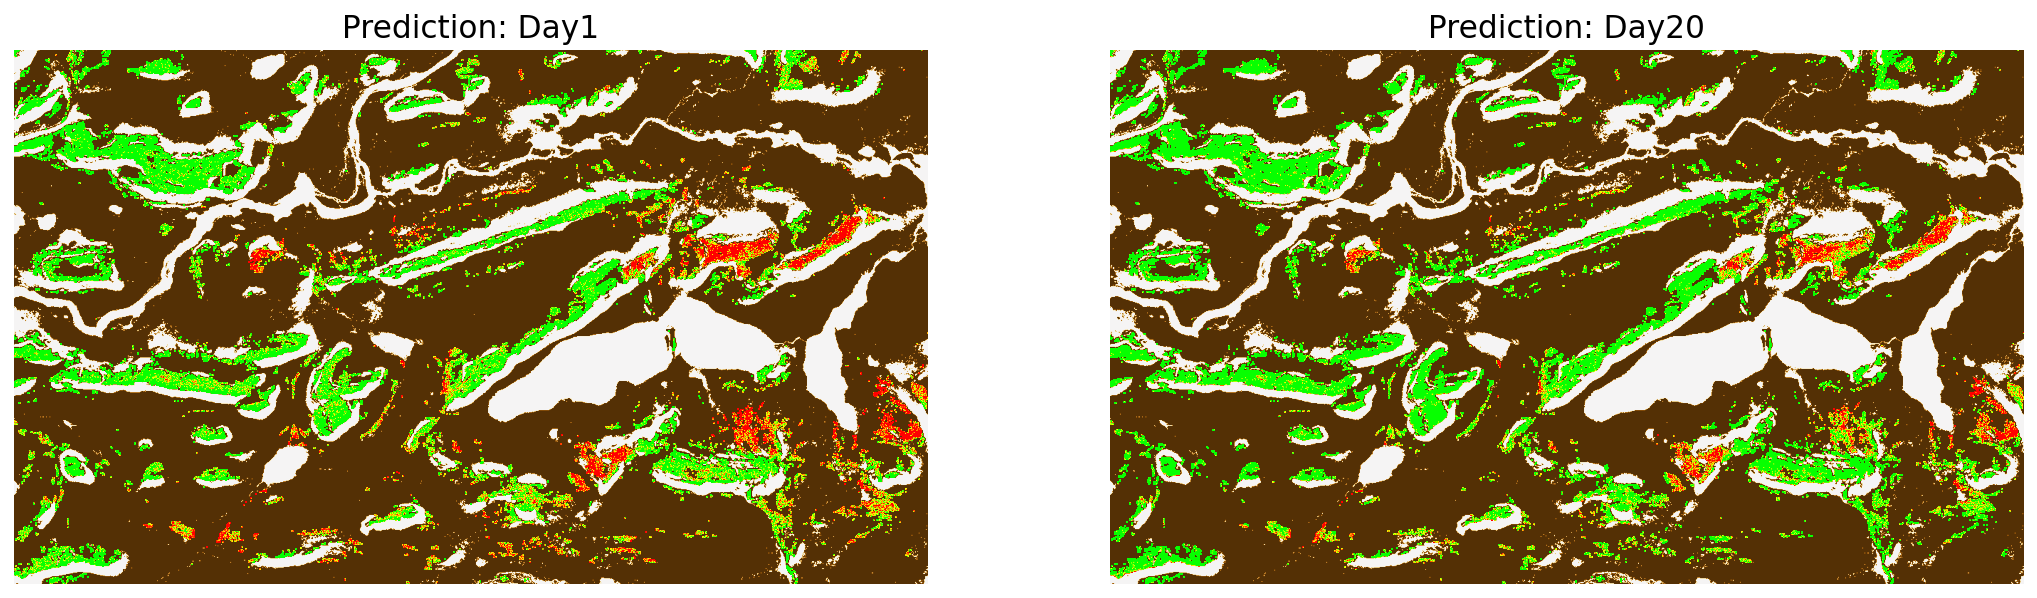

In [ ]:
plt.figure(figsize=(18,6))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_map[Day],cmap ='hsv',vmin = 0,vmax = 3)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Prediction: '+Day)
    i = i+1

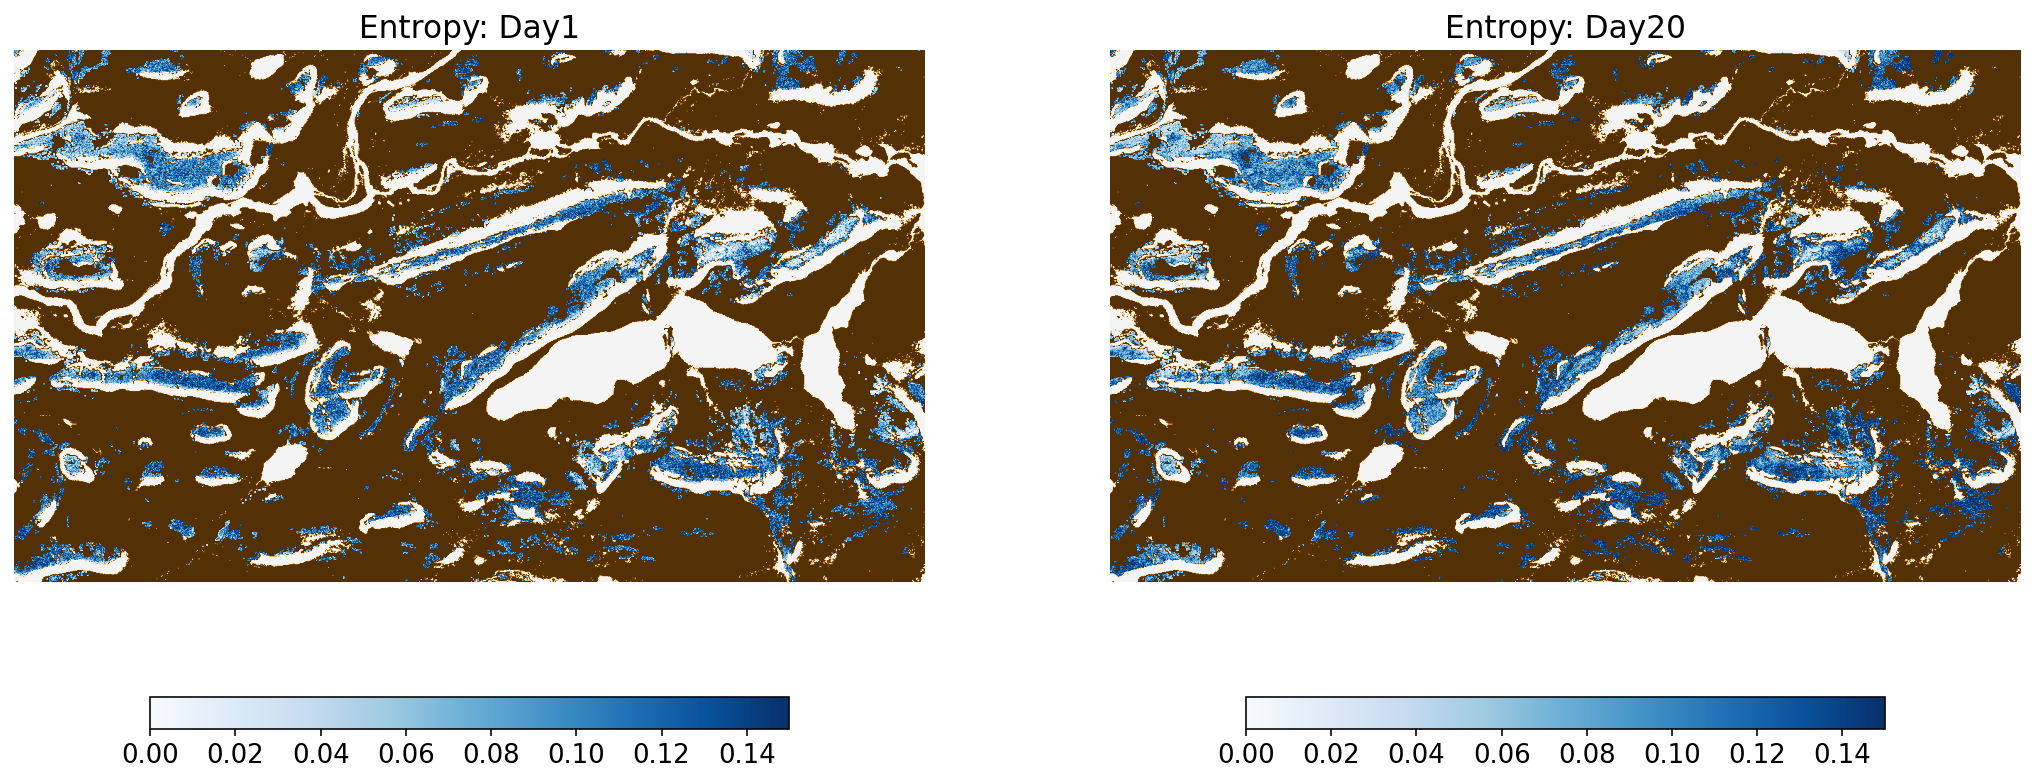

In [ ]:
plt.figure(figsize=(18,7))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_entropy[Day],cmap = 'Blues',vmin = 0,vmax = 0.15)
    plt.colorbar(orientation = 'horizontal',shrink = 0.7)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Entropy: '+Day)
    i = i+1

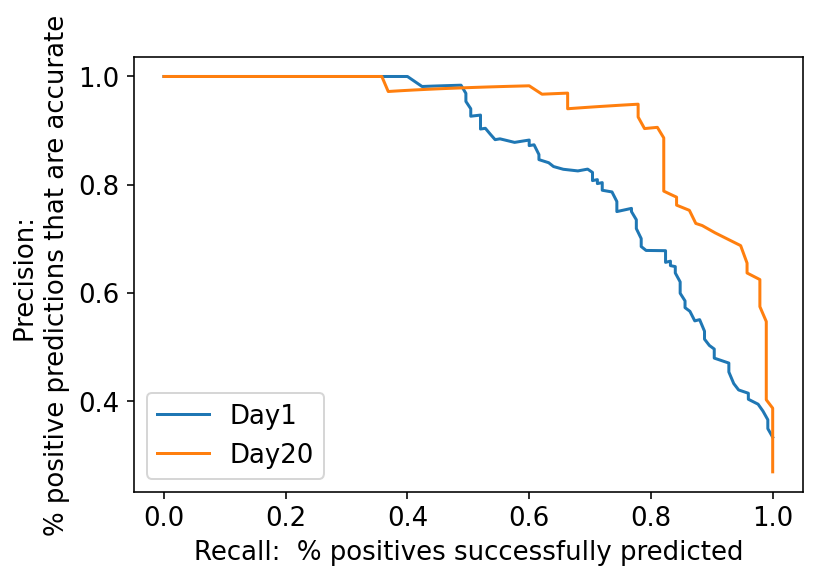

In [ ]:
for Day in ['Day1','Day20']:
    PR = np.array([precision_recall(results['Logistic Regression '+Day], threshold,
                                    y_test_list[Day]) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = Day)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()

## CART

In [5]:
import sklearn.tree as tree

In [ ]:
pred_map = {}
results = {}
pred_entropy = {}
y_test_list = {}

In [ ]:
for Day in ['Day1','Day20']:
    if Day == 'Day1':
        X = np.copy(X_Day1)
        y = np.copy(y_Day1)
    elif Day == 'Day20': 
        X = np.copy(X_Day20)
        y = np.copy(y_Day20)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    clf_CART = tree.DecisionTreeClassifier(random_state=0, 
                                           criterion='gini',
                                           max_depth = 5,
                                           min_samples_leaf =15,
                                          ).fit(X_train,  y_train)

    # inference: test dataset
    y_test_list[Day] = y_test
    results['CART '+Day] = clf_CART.predict_proba(X_test)
    
    # inference: full map
    y_pred_prob = clf_CART.predict_proba(X_all)
    y_pred = np.argmax(y_pred_prob,axis = 1)

    y_pred = np.array(y_pred.reshape(WV_band['band00'].shape),dtype = 'float64')
    pred_map[Day] = y_pred
    
    # inference: entropy
    entropy = -y_pred_prob[:,0]*np.log10(y_pred_prob[:,0])
    entropy = entropy.reshape(WV_band['band00'].shape)
    pred_entropy[Day] = entropy

In [ ]:
'red: peridotite, 0'
'green: basalt, 1'

'green: basalt, 1'

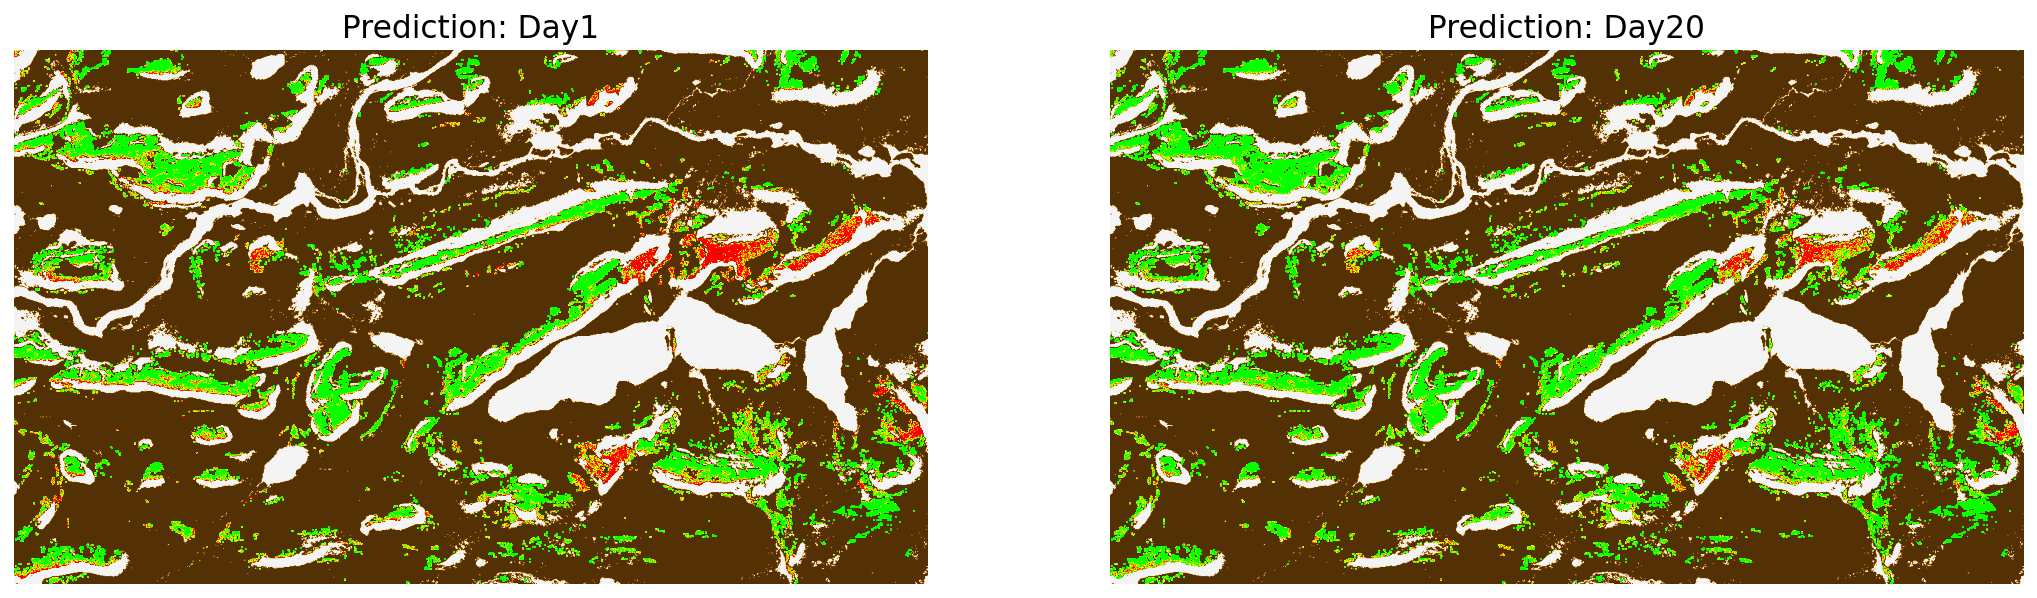

In [ ]:
plt.figure(figsize=(18,6))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_map[Day],cmap ='hsv',vmin = 0,vmax = 3)
#     plt.colorbar()
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    
    plt.axis('off')
    plt.title('Prediction: '+Day)
    i = i+1

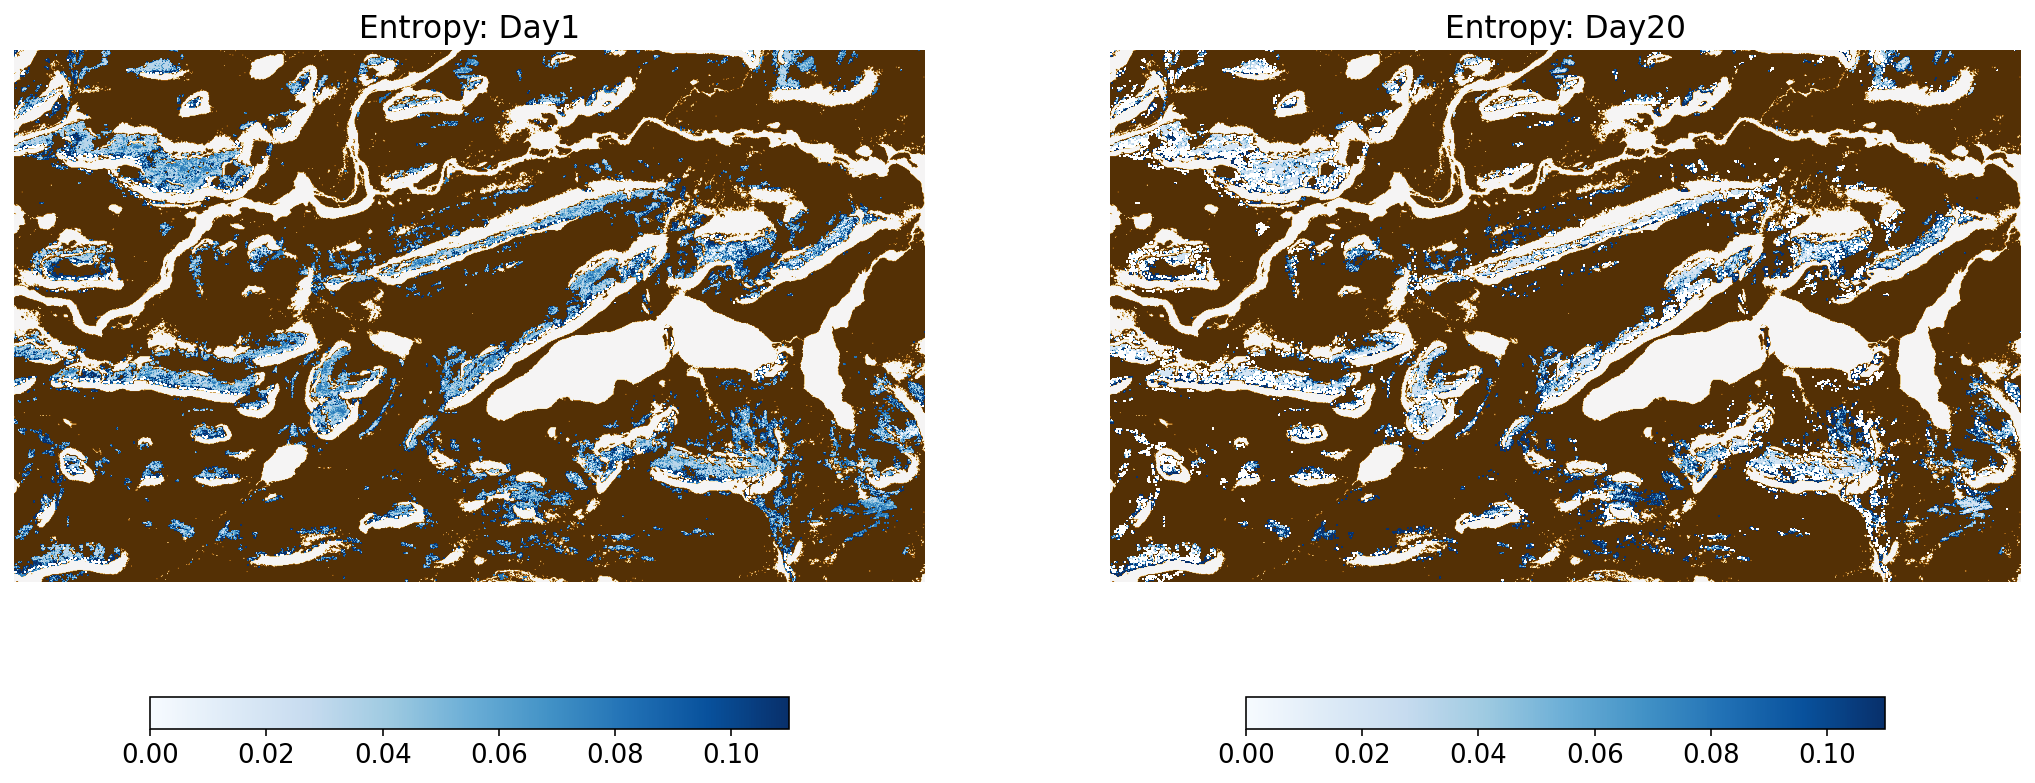

In [ ]:
plt.figure(figsize=(18,7))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_entropy[Day],cmap = 'Blues',vmin = 0,vmax = 0.11)
    plt.colorbar(orientation = 'horizontal',shrink = 0.7)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Entropy: '+Day)
    i = i+1

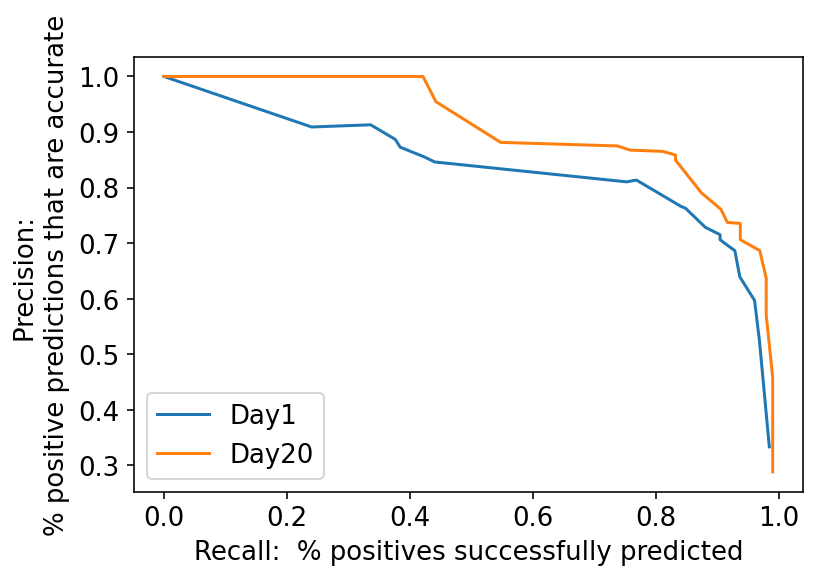

In [ ]:
for Day in ['Day1','Day20']:
    PR = np.array([precision_recall(results['CART '+Day], threshold,
                                    y_test_list[Day]) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = Day)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()
plt.show()